# HW 1 for Projects in ML and AI

In [2]:
# installing dependencyes

!pip install -q kaggle

In [3]:
# mount drive and set up kaggle API

from google.colab import drive
drive.mount('/content/drive')

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive
rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
# install dataset and unzip

!rm -r dataset

!kaggle datasets download -d saumitgp/occupancy-detection-dataset
!mkdir dataset
!unzip occupancy-detection-dataset.zip -d dataset

rm: cannot remove 'dataset': No such file or directory
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 50.2MB/s]
Archive:  occupancy-detection-dataset.zip
  inflating: dataset/OccupancyData/DataTest.csv  
  inflating: dataset/OccupancyData/DataTraining.csv  


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# the balance is weird, I will merge the train and test files first and split them to 8:2
df = pd.concat([pd.read_csv('dataset/OccupancyData/DataTraining.csv',index_col=[0]),
                pd.read_csv('dataset/OccupancyData/DataTest.csv',index_col=[0])])
X = df.drop(columns=['date'])
y = X.pop('Occupancy')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=0)


Task 1 (10 points): Describe a machine learning problem that you would like to solve using 
Logistic Regression. Clearly state why Logistic regression is the best choice for solving this 
problem.

## Task 1

The problem of detecting occupancy in a room (classificaion) can be solved using a classification algorithm and training on various features, such as light, co2, temperature, and humidity of a room. I found a dataset called occupation detection on [Kaggle](https://www.kaggle.com/datasets/saumitgp/occupancy-detection-dataset). The original dataset seems to be from [here](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). The kaggle version seems to have similar number of rows, so I decided to stick to the Kaggle version


Task 2 (20 points): Pick a publicly available dataset (except The Titanic Dataset because we 
already discussed that in class) that you will use to solve this problem. You must provide a link 
to the dataset and perform necessary Exploratory Data Analysis (EDA). Clearly demonstrate the 
steps you follow for your EDA with a justification of why these were required. For example, if 
the dataset has lot of missing values, then why did you use a specific technique when handling 
missing data. This task may include data visualization (Check this link : 
https://www.geeksforgeeks.org/top-8-python-libraries-for-data-visualization/).

## Task 2

First, we read in dataset and make a pretty df

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# the balance is weird, I will merge the train and test files first and split them to 8:2
df = pd.concat([pd.read_csv('dataset/OccupancyData/DataTraining.csv',index_col=[0]),
                pd.read_csv('dataset/OccupancyData/DataTest.csv',index_col=[0])])
X = df.drop(columns=['date'])
y = X.pop('Occupancy')

X_train,X_test,y_train,y_test = train_test_split(X.values,y.values,test_size=.2,random_state=0)

Check for NA values, and also for correlation between feature values.


We find no NA values, and the correlation seems OK! (high corr between humidity ratio and humidity itself is to be expected). I believe this shows that the dataset is adequate to be used for a binary classification task using Logistic Regression, because each variable seems to be independent of each other. 

I also checked the distribution of the labels, it seems that we have more entries for 'No Occupancy' than 'Occupancy'. 

checking if there is nan in any column
Temperature      False
Humidity         False
Light            False
CO2              False
HumidityRatio    False
dtype: bool


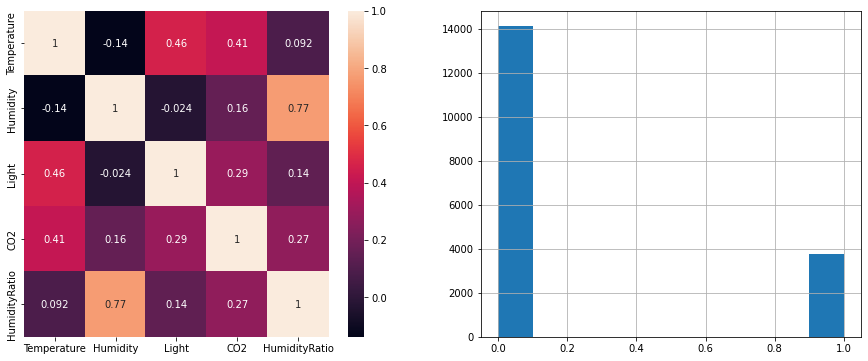

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

print('checking if there is nan in any column')
print(X.isna().any())

fig,axes = plt.subplots(ncols=2,figsize=(15,6))
sns.heatmap(
    X.corr(method='kendall'),
    ax=axes[0],
    annot=True
)

y.hist(ax=axes[1])

Task 3 (35 points): Implement, Logistic Regression in this step. Clearly write your cost function 
and derivatives before implementing gradient descent. Do not use any built-in packages for this 
step. You can use the vectorization techniques demonstrated in class. Implement any 2 variants 
of gradient descent in their original form. (Refer to the research paper discussed in class).

## Task 3

In [99]:
import numpy as np 
from tqdm.auto import tqdm
import random

np.random.seed(0)
random.seed(0)
# tiny offset to avoid zero division in logs
OFFSET = 1e-7

# My Activation and Cost functions (Both taken from lecture)
activation = lambda x: (1/(1+np.exp(-x)))
loss = lambda real,pred: -(real*np.log(pred+OFFSET) + (1-real)*np.log(1-pred+OFFSET))

class LogisticRegression():
    def __init__(self, learning_rate = 1e-3,n_iter=1000,batch_size = None,mode = 'vanilla'):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.mode = mode

    def fit(self,X_train,y_train):
        if not self.batch_size: self.batch_size = X_train.shape[0]
        self.W = np.random.random((1,X_train.shape[1]))
        self.B = np.random.random(1)
        self.old_dW = np.zeros((self.n_iter,X_train.shape[1]))
        self.old_dB = np.zeros(self.n_iter)
        self.losses = np.zeros(self.n_iter)

        grad_func = {
            'vanilla': self.vanilla_update,
            'adagrad': self.adagrad_update,
        }

        for i in tqdm(range(self.n_iter),desc='training...'):
            X_sample,y_sample = self.get_batch(X_train,y_train)
            # for b in range(n_batches):
            grad_func[self.mode](X_sample,y_sample,i)

    def get_batch(self,X_train,y_train):
        idxs = np.arange(X_train.shape[0])
        np.random.shuffle(idxs)
        return X_train[idxs[:self.batch_size]],y_train[idxs[:self.batch_size]]

    
    def vanilla_update(self,X_sample,y_sample,iter):
        y_hat = self.predict_prob(X_sample)
        l = loss(y_sample,y_hat)
        # dW = (X_train * l).mean(0) 
        dW = X_sample.T @ (y_hat - y_sample)
        # dW = (X_train.T * (y_hat - y_train)).mean(1)
        dB = (y_hat - y_sample).mean()
        self.W -= dW * self.learning_rate
        self.B -= dB * self.learning_rate
        self.losses[iter] = l.sum()

    def adagrad_update(self,X_sample,y_sample,iter):
        y_hat = self.predict_prob(X_sample)
        l = loss(y_sample,y_hat)
        dW = X_sample.T @ (y_hat - y_sample)
        dB = (y_hat - y_sample).mean()
        self.old_dW[iter] = dW
        self.old_dB[iter] = dB
        # adjust our learning rate
        self.W -= dW * self.learning_rate / (np.sqrt((self.old_dW ** 2).sum(0)) + OFFSET)
        self.B -= dB * self.learning_rate / (np.sqrt((self.old_dB ** 2).sum(0)) + OFFSET)
        self.losses[iter] = l.sum()


    def predict_prob(self,X):
        # Added slicing at end to return it flat
        return activation(X @ self.W.T + self.B)[:,0]

    def predict(self,X):
        return (self.predict_prob(X) > .5).astype(int)

    def score(self,X,y):
        pred = self.predict(X)
        return (y == pred).mean()


In [97]:
W = np.random.random((1,X_train.shape[1]))
B = np.random.random(1)
y_hat = activation(X_train @ W.T + B)[:,0]
dW = X_train.T @ (y_hat - y_train)
dW

array([2.32239204e+05, 3.15684048e+05, 2.88248633e+05, 6.90950578e+06,
       4.71240710e+01])

In [101]:
results = []
for mode in ['vanillna','adagrad']:
    for n in [1000,2000,5000]:
        for lr in [5,2,1,.01,.001,.0001]:
            clf = LogisticRegression(n_iter=n,learning_rate=lr,mode=mode)
            clf.fit(X_train,y_train)
            output = {'mode':mode,'n':n,'lr':lr,'train':clf.score(X_train,y_train),'test':clf.score(X_test,y_test),}
            print(output)
            results.append({**output,'model':clf})

training...:   0%|          | 0/1000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 1000, 'lr': 0.01, 'train': 0.16813355685945794, 'test': 0.17826208438111205}


training...:   0%|          | 0/1000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 1000, 'lr': 0.001, 'train': 0.21032411288069294, 'test': 0.21430567197541212}


training...:   0%|          | 0/1000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 1000, 'lr': 0.0001, 'train': 0.21032411288069294, 'test': 0.21430567197541212}


training...:   0%|          | 0/2000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 2000, 'lr': 0.01, 'train': 0.1808466051969824, 'test': 0.189158982956133}


training...:   0%|          | 0/2000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 2000, 'lr': 0.001, 'train': 0.21032411288069294, 'test': 0.21430567197541212}


training...:   0%|          | 0/2000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 2000, 'lr': 0.0001, 'train': 0.21032411288069294, 'test': 0.21430567197541212}


training...:   0%|          | 0/5000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 5000, 'lr': 0.01, 'train': 0.9711511595417714, 'test': 0.9645152277172394}


training...:   0%|          | 0/5000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 5000, 'lr': 0.001, 'train': 0.21032411288069294, 'test': 0.21430567197541212}


training...:   0%|          | 0/5000 [00:00<?, ?it/s]

{'mode': 'adagrad', 'n': 5000, 'lr': 0.0001, 'train': 0.21032411288069294, 'test': 0.21430567197541212}


Task 4 (35 points): Pick any 2 optimization algorithms that are used to optimize the ‘vanilla’
gradient descent. Implement both. You may implement these algorithms yourself OR use a 
package. In your conclusion, compare both optimization techniques/algorithms with respect to 
the results you achieve. Also compare these results with the original implementation of 
gradient descent (Task 3 above). Describe why or why not should we use optimization 
algorithms for the task at hand

## Task 4

Q: Does this mean stuff like SGD or using different solvers?